In [5]:
import os
import re
import cv2
import json
import array
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import OpenEXR
import Imath
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage
from collections import defaultdict
import matplotlib.patches as mpatches

In [6]:
def generate_cognitive_map(instance_mask, xyz_map, id_to_class, grid_size=(20, 20)):
    """
    参数:
        instance_mask: H x W 的 numpy 数组，实例分割灰度图，每个像素值是实例ID
        xyz_map: H x W x 3 的 numpy 数组，存储每个像素的 3D 坐标
        id_to_class: 字典，{instance_id: class_name}
        grid_size: 空间认知图划分的网格尺寸 (rows, cols)
    返回:
        空间认知图的可视化
    """
    # 提取每个实例的 3D 中心
    instance_positions = {}
    for instance_id in np.unique(instance_mask):
        if instance_id == 0:  # 背景忽略
            continue
        mask = instance_mask == instance_id
        coords = xyz_map[mask]
        coords = coords[~np.isnan(coords).any(axis=1)]  # 去除无效值
        if len(coords) == 0:
            continue
        center = np.median(coords, axis=0)  # 使用中位数避免离群值
        instance_positions[instance_id] = center

    # 计算全体的空间范围用于网格归一化
    all_centers = np.array(list(instance_positions.values()))
    min_xyz = np.min(all_centers, axis=0)
    max_xyz = np.max(all_centers, axis=0)

    # 构建空白网格图
    grid = [[[] for _ in range(grid_size[1])] for _ in range(grid_size[0])]

    for inst_id, center in instance_positions.items():
        normalized = (center - min_xyz) / (max_xyz - min_xyz + 1e-6)  # 避免除以0
        grid_y = min(int(normalized[1] * grid_size[0]), grid_size[0] - 1)
        grid_x = min(int(normalized[0] * grid_size[1]), grid_size[1] - 1)
        class_name = id_to_class.get(inst_id, f"id{inst_id}")
        grid[grid_y][grid_x].append(class_name)

    # 可视化空间认知图
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])
    ax.invert_yaxis()
    ax.set_xticks(np.arange(0, grid_size[1]+1))
    ax.set_yticks(np.arange(0, grid_size[0]+1))
    ax.grid(True)

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            items = grid[i][j]
            if items:
                label = '\n'.join(sorted(set(items)))
                ax.text(j + 0.5, i + 0.5, label, ha='center', va='center', fontsize=8, wrap=True)

    ax.set_title("Spatial Cognitive Map", fontsize=16)
    plt.tight_layout()
    plt.show()

In [7]:
# 读取exr文件
def read_exr( image_fpath ):
    """ Reads an openEXR file into an RGB matrix with floats """
    f = OpenEXR.InputFile( image_fpath )
    dw = f.header()['dataWindow']
    w, h = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)    
    im = np.empty( (h, w, 3) )

    # Read in the EXR
    FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
    channels = f.channels( ["R", "G", "B"], FLOAT )
    for i, channel in enumerate( channels ):
        im[:,:,i] = np.reshape( array.array( 'f', channel ), (h, w) )
    return im

""" Label functions """
def load_labels( label_file ):
    """ Convenience function for loading JSON labels """
    with open( label_file ) as f:
        return json.load( f )

def parse_label( label ):
    """ Parses a label into a dict """
    res = {}
    clazz, instance_num, room_type, room_num, area_num = label.split( "_" )
    res[ 'instance_class' ] = clazz
    res[ 'instance_num' ] = int( instance_num )
    res[ 'room_type' ] = room_type
    res[ 'room_num' ] = int( room_num )
    res[ 'area_num' ] = int( area_num )
    return res

def get_index(color):
    """ Parse a color as a base-256 number and return the index """
    r, g, b = map(int, color)  # 👈 转换为 Python int 类型，避免 uint8 溢出
    return r * 256 * 256 + g * 256 + b

In [8]:
pano_dir = "/hpc2hdd/home/yhuang489/ylguo/PanoData/area_3/area_3/pano/rgb"
xyz_dir = "/hpc2hdd/home/yhuang489/ylguo/PanoData/area_3/area_3/pano/global_xyz"
instance_dir = "/hpc2hdd/home/yhuang489/ylguo/PanoData/area_3/area_3/pano/semantic"
semantic_label_path = "/hpc2hdd/home/yhuang489/ylguo/PanoCode/2D-3D-Semantics/assets/semantic_labels.json"

In [9]:
# 全景图像
pano_list = os.listdir(pano_dir)
print(len(pano_list))
pano_name = pano_list[34]
print(pano_name)
pano_path = os.path.join(pano_dir, pano_name)
# 实例分割标签
instance_name = pano_name.replace('rgb', 'semantic')
instance_path = os.path.join(instance_dir, instance_name)
# 3D标注
xyz_name = pano_name.replace('rgb.png', 'global_xyz.exr')
xyz_path = os.path.join(xyz_dir, xyz_name)

86
camera_505548017eed4d4da09b369be5ecb160_lounge_2_frame_equirectangular_domain_rgb.png


In [11]:
# 读取3D标注
xyz_image = read_exr(xyz_path)
# 读取实例分割标签
instance_image = Image.open(instance_path)
np_instance_image = np.array(instance_image)
semantic_labels = load_labels(semantic_label_path)
instance_index = np.zeros([2048, 4096])
# 映射到实例分割物体分类的Index
for i in range(2048):
    for j in range(4096):
        class_index = get_index(np_instance_image[i, j])
        if class_index < 9816:
            instance_index[i, j] = class_index
        else:
            instance_index[i, j] = 0
instance_ids = np.unique(instance_index)
instance_ids = instance_ids[instance_ids < 9816]
# class_index-class_name映射
id_map = dict()
for inst_id in instance_ids:
    # 在标签中寻找这个inst_id对应的实例类别
    label = parse_label(semantic_labels[int(inst_id)])
    id_map[inst_id] = label["instance_class"]

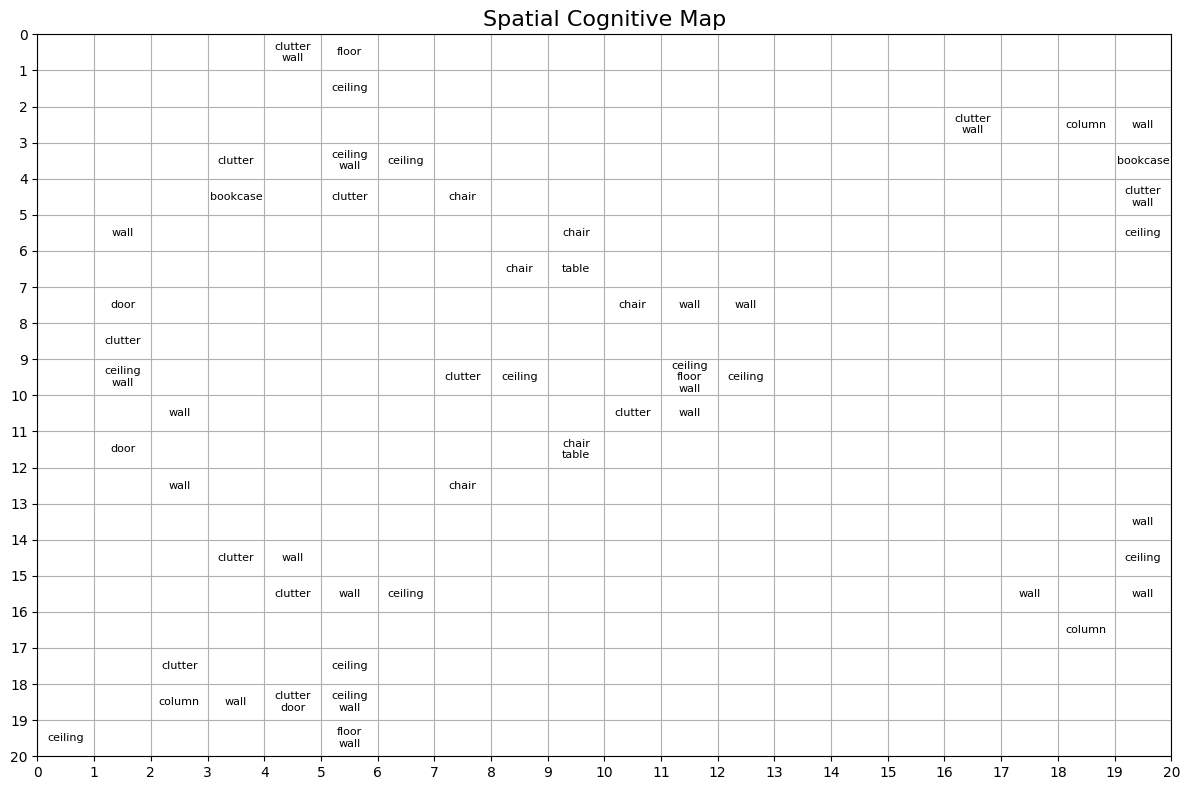

In [12]:
generate_cognitive_map(instance_index, xyz_image, id_map)

In [13]:
pano_image = np.array(Image.open(pano_path))
fig, axis = plt.plot(